# Lab4. Amazon Kinesis Data Analytics RCF

This notebook shows how to compute an anomaly score using [RANDOM_CUT_FOREST_WITH_EXPLANATION](https://docs.aws.amazon.com/kinesisanalytics/latest/sqlref/sqlrf-random-cut-forest-with-explanation.html) in Amazon Kinesis Data Analytics for each record in clickstreams. After creating Kinesis Data streams for source and destination streams, Amazon Kinesis Data Analytics will detect anomalies in the input data stream. Records which are distant from other records will have higher anomaly score. The algorithm starts developing the machine learning model using current records in the stream when you start the Kinesis application. The algorithm does not use older records in the stream for machine learning, nor does it use statistics from previous executions of the application.

## Table Of Contents
The overall process for this is:

1. Setup
1. Creating Kineais streams  
    2-1. Createing Kinesis data streams  
    2-2. Creating IAM Role  
    2-3. Creating the Kinesis Data Analytics Application  
    2-4. Starting the Kinesis Data Analytics Application  
1. Sending Input streams  
    3-1. Data preparation  
    3-2. Sending data
1. Plotting the Prediction
1. Stopping and Deleting the Kinesis Data Analytics Application
1. (Optional) Comparison by timedecay parameter

To get started, simply execute the cells below:

## 1. Setup

Install AWS Data Wrangler. AWS Data Wrangler will put the anomaly detection results to Amazon S3 while running Amazon Kinesis Data Analytics.

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install awswrangler

  Using cached pip-20.2.3-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 134 kB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 10.9 MB/s eta 0:00:01
  Using cached sqlalchemy_redshift-0.8.1-py2.py3-none-any.whl (33 kB)
     |████████████████████████████████| 17.3 MB 80.5 MB/s eta 0:00:01


In [153]:
import json
import random
import boto3
import os
import time
import numpy as np
import pandas as pd
import awswrangler as wr

import matplotlib.pyplot as plt

%matplotlib inline 

In [154]:
kinesis_client = boto3.client('kinesis')
kinesis_analytics = boto3.client('kinesisanalytics')

In [155]:
sess = boto3.Session()

# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 's3://sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
job_bucket

's3://sagemaker-experiments-us-east-1-308961792850'

In [156]:
%store -r

## 2. Creating Kinesis streams

### 2-1. Create Kinesis data streams

We need to create Kinesis resources. Since we use boto3 SDK to create all aws resource we use, you don't need to visit AWS console in this lab. But you may check the status or results in the console intermitantly during the process.

First, we create Kinesis data stream that serves as a short term streaming store for clickstreams. The throughput of an Amazon Kinesis data stream is determined by the number of shards within the data stream. We will use 1 for this example. You can calculate the initial number of shards (number_of_shards) the data stream needs using the following formula:

number_of_shards = max (incoming_write_bandwidth_in_KB/1000, outgoing_read_bandwidth_in_KB/2000)

In [157]:
data_stream = ['clickstream_input', 'clickstream_output']

try:
    for stream in data_stream:
        kinesis_client.create_stream(
            StreamName=stream,
            ShardCount=1
        )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])
    

Stream clickstream_input under account 308961792850 already exists.


In [158]:
# Wait until all streams are created
result = {}
waiter = kinesis_client.get_waiter('stream_exists')
for stream in data_stream:
    waiter.wait(StreamName=stream)
    response = kinesis_client.describe_stream(StreamName=stream)
    result[stream] = response["StreamDescription"]["StreamARN"]

#### (Optional) Checking result in the console
After the execution, you can find two Kinesis Data streams in the console:
- Amazon Kinesis > Data streams
![](imgs/Kstream-console.png)

### 2-2. Creating IAM Role

In this step, we create an IAM role and add an policy that we will use in the Kinesis to read inputstream and write outputstream.

In [159]:
region = boto3.Session().region_name

iam = boto3.client('iam')
sts = boto3.client('sts')

In [160]:
kinesis_role_name = 'kinesis-analytics-{}'.format(region)
kinesis_analytics_policy_name=kinesis_role_name + '_policy'
kinesis_role_name

'kinesis-analytics-us-east-1'

In [161]:
kinesis_assume_role={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "kinesisanalytics.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}
kinesis_analytics_policy = {
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "ReadInputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:GetShardIterator",
        "kinesis:GetRecords"
      ],
      "Resource": [
        result['clickstream_input']
      ]
    },
    {
      "Sid": "WriteOutputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:PutRecord",
        "kinesis:PutRecords"
      ],
      "Resource": [
        result['clickstream_output']
      ]
    }
  ]
}

In [162]:
try:
    role_res = iam.create_role(
        Path='/service-role/',
        RoleName=kinesis_role_name,
        AssumeRolePolicyDocument=json.dumps(kinesis_assume_role),
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_res = iam.get_role(
            RoleName=kinesis_role_name
        )
        print("Role already exists")
    else:
        print("Unexpected error: %s" % e)

Role already exists


In [163]:
try:
    policy_res = iam.create_policy(
        PolicyName=kinesis_analytics_policy_name,
        Path='/',
        PolicyDocument=json.dumps(kinesis_analytics_policy)
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        PolicyArn ='arn:aws:iam::{}:policy/{}'.format(account_id, kinesis_analytics_policy_name)
        policy_res = iam.get_policy(
            PolicyArn=PolicyArn
        )
        print("Policy already exists")
    else:
        print("Unexpected error: %s" % e)

Policy already exists


In [164]:
from botocore.exceptions import ClientError

try:
    attach_res = iam.attach_role_policy(
        PolicyArn=policy_res['Policy']['Arn'],
        RoleName=kinesis_role_name
    )
    print("Policy has been succesfully attached to role: %s" % kinesis_role_name)
except Exception as e:
    print("Unexpected error: %s" % e)

Policy has been succesfully attached to role: kinesis-analytics-us-east-1


### 2-3. Creating the Kinesis Data Analytics Application


We will configure Kinesis Data Analytics application to process the Kinesis data stream we created as the streaming source. You can add SQL and the destination stream in Kinesis Analytics with the code below. The parameters of the RANDOM_CUT_FOREST_WITH_EXPLANATION function are defined as numberOfTrees, subSampleSize, timeDecay, shingleSize, and withDirectionality.

* **numberOfTrees** : the number of random cut trees in the forest. 
* **subSampleSize** : the size of the random sample that you want the algorithm to use when constructing each tree
* **timeDecay** : how much of the recent past to consider when computing an anomaly score
* **shingleSize** : the size of the consecutive sequence of the most recent records. For example, a shingleSize of 10 at time t corresponds to a vector of the last 10 records received up to and including time t. The algorithm treats this sequence as a vector over the last shingleSize number of records. If you set the shingleSize too small, the algorithm is more susceptible to minor fluctuations in the data, leading to high anomaly scores for records that are not anomalous.
If you set the shingleSize too large, it might take more time to detect anomalous records because there are more records in the shingle that are not anomalous. It also might take more time to determine that the anomaly has ended.
* **withDirectionality** : When set to true, it tells you the direction in which each individual dimension makes a contribution to the anomaly score. It also provides the strength of the recommendation for that directionality.

In this sample code, we set timeDecay as 4,320 (=60x24x3) which means we will take previous 3 days events into consideration. 

In [189]:
%%writefile random_cut_forest_with_explanation.sql

-- ** Anomaly detection **
-- Compute an anomaly score for each record in the source stream using Random Cut Forest
-- Creates a temporary stream and defines a schema
                                
CREATE OR REPLACE STREAM "TEMP_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));
-- Creates an output stream and defines a schema
CREATE OR REPLACE STREAM "DESTINATION_SQL_STREAM" (
   "TIMESTAMPS"          TIMESTAMP,
   "URLS"                INTEGER,
   "USERS"               INTEGER,
   "CLICKS"              INTEGER,
   "ANOMALY_SCORE"       DOUBLE,
   "ANOMALY_EXPLANATION" varchar(512));


-- RANDOM_CUT_FOREST anomaly score is a number between 0 and LOG2(subSampleSize)
-- See RANDOM_CUT_FOREST anomaly score explanation https://forums.aws.amazon.com/message.jspa?messageID=751928
-- Normalize the "ANOMALY_SCORE" by dividing it by LOG2(subSampleSize)
--   "shingleSize": 4, 24, 48
--    "numberOfTrees" : 100, 200

CREATE OR REPLACE PUMP "STREAM_PUMP" AS INSERT INTO "TEMP_STREAM"
SELECT STREAM "TIMESTAMPS", "URLS", "USERS", "CLICKS", "ANOMALY_SCORE", "ANOMALY_EXPLANATION" FROM
  TABLE(RANDOM_CUT_FOREST_WITH_EXPLANATION(
    CURSOR(SELECT STREAM * FROM "SOURCE_SQL_STREAM_001"), -- inputStream
    100, -- numberOfTrees
    256, -- subSampleSize
    4320, -- timeDecay (60m x 24h x 3d) (default 100000)
    1, -- shingleSize
    true
  )
);

CREATE OR REPLACE PUMP "OUTPUT_PUMP" AS INSERT INTO "DESTINATION_SQL_STREAM"
SELECT STREAM * FROM "TEMP_STREAM"
ORDER BY FLOOR("TEMP_STREAM".ROWTIME TO SECOND), ANOMALY_SCORE DESC;

Overwriting random_cut_forest_with_explanation.sql


In [190]:
sql_query = open('random_cut_forest_with_explanation.sql', "r").read()
kinesis_ApplicationName='clickstream-analytics-rcf-explanation-{}'.format(int(time.time()))

In [191]:
try:
    response = kinesis_analytics.create_application(
        ApplicationName=kinesis_ApplicationName,
        ApplicationCode=sql_query,
        Inputs=[
            {
                'NamePrefix': 'SOURCE_SQL_STREAM',
                'KinesisStreamsInput': {
                    'ResourceARN': result[data_stream[0]],
                    'RoleARN': role_res['Role']['Arn']
                },
                'InputSchema': {
                    'RecordFormat': {
                        'RecordFormatType': 'JSON',
                        'MappingParameters': {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        }
                    },
                    'RecordEncoding': 'UTF-8',
                    'RecordColumns': [
                                {
                                    "SqlType": "TIMESTAMP",
                                    "Name": "TIMESTAMPS",
                                    "Mapping": "$.timestamp"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "URLS",
                                    "Mapping": "$.urls"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "USERS",
                                    "Mapping": "$.users"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "CLICKS",
                                    "Mapping": "$.clicks"
                                }
                    ],
                    "RecordFormat": {
                        "MappingParameters": {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        },
                        "RecordFormatType": "JSON"
                      }
                }
            },
        ],
        Outputs=[
            {
                'Name': 'DESTINATION_SQL_STREAM',
                'DestinationSchema': {
                    'RecordFormatType': 'JSON'
                },
                "KinesisStreamsOutput": {
                    "ResourceARN": result[data_stream[1]],
                    "RoleARN": role_res['Role']['Arn']
                }
            },
        ],
    )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e)

#### (Optional) Checking result in the console
After the execution, you can find Kinesis Analytics Application (in ready status) in the console:
- Amazon Kinesis > Analytics Applciation
![](imgs/Kapplication-ready.png)

### 2-4. Starting the Kinesis Data Analytics Application

Start the Amazon Kinesis Analytics application. After the application starts, it begins consuming the input data, processes it, and writes the output to the configured destination.

In [192]:
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)

application = response["ApplicationDetail"]
inputId = application['InputDescriptions'][0]['InputId']

try:
    kinesis_analytics.start_application(ApplicationName=kinesis_ApplicationName,
                                     InputConfigurations=[{
                                       "Id": inputId,
                                       "InputStartingPositionConfiguration": {
                                         "InputStartingPosition": "NOW"
                                       }
                                     }])
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

In [193]:
# Wait until application starts running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write('Starting ')
while status != "RUNNING":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
      ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('RUNNING')
sys.stdout.write(os.linesep)

Starting ................................................RUNNING


#### (Optional) Checking result in the console
After the execution, you can find Kinesis Analytics Application (in running status) in the console:
- Amazon Kinesis > Analytics Applciation
![](imgs/Kapplication-running.png)

## 3. Sending Input streams

### 3-1. Data Preparation
We use aggagated timeseries as input data, which have 3 features of the number of visited urls, the number of visitors, and the numbor of clicks in 1 minute.

In [194]:
# restored dataset from Lab1
clickstream_1T.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


This is the same data we used in the previous lab.

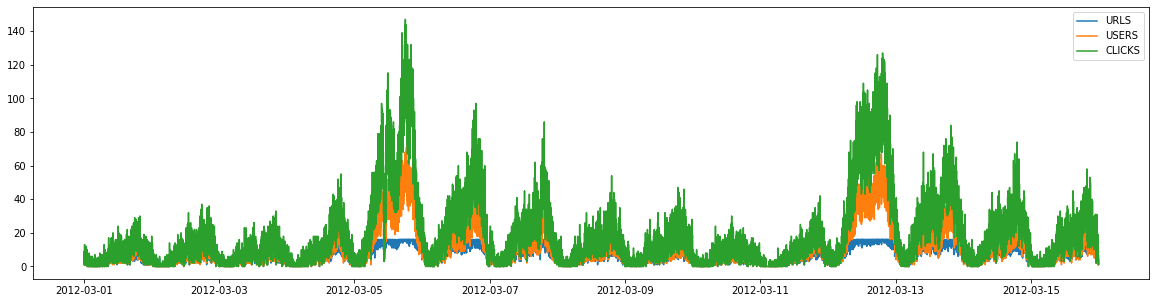

In [195]:
plt.figure(figsize=(20,5))
plt.plot(clickstream_1T)
plt.legend(legend)
plt.show()

Prepare a utility function to generate input data in Kiensis put_record format.

In [196]:
clickstream_1T_wt = clickstream_1T.reset_index()
col_names = clickstream_1T.reset_index().keys().to_list()

# This function trasnforms input dfatafram to Kinesis put_record json
def make_kinesis_data(df, i, col_names):
    kinesis_data = {}
    kinesis_data['timestamp']=str(df['timestamp'][i])
    for col_name in col_names:
        if col_name not in ['timestamp']:
            kinesis_data[col_name]=int(df.iloc[i][col_name])
    return kinesis_data

make_kinesis_data(clickstream_1T_wt.reset_index(), 0, col_names)

{'timestamp': '2012-03-01 00:00:00', 'urls': 3, 'users': 4, 'clicks': 5}

Prepare another function to write the result to the S3

In [197]:
# This function saves the results from Kinesis Analytics into the S3
def s3_sink(shardIterator):
    rows = []
    response = kinesis_client.get_records(ShardIterator=shardIterator)
    records = response["Records"]

    try:
        while len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            time.sleep(1)
            shardIterator = response["NextShardIterator"]
            response = kinesis_client.get_records(ShardIterator=shardIterator)
            records = response["Records"]
        flag = rows[0]['TIMESTAMPS'].replace(":","-").replace(" ","-").replace(".","-")
        s3_save_path = '{}/{}/{}'.format(job_bucket, 'kinesis-analytics', flag)
        wr.s3.to_csv(
            df=pd.DataFrame(rows),
            path=s3_save_path
        )
    except:
        sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
        pass
    return rows

### 3-2. Sending data


<!-- Similar to streaming data in real-time, we put clickstreams into Kinesis Data Analytics through Kinesis Data Stream by one record using For statement. Anomaly scores and explanations will be added to clickstreams through Kinesis analytics. -->
Now let's send the data to the Kiensis input data stream.  

By executing below code, you will:  

1) Send clickstream data into Kinesis data stream (`clickstream_input`).    
2) Write the anomaly score of output stream(`clickstream_output`) in the S3.  
3) Append the anomaly score to the `result` list to check the result.  

We used the APIs in Kinesis:
- [put_record](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_PutRecord.html) - in following cell (inside the `for` loop)
- [get_records](https://docs.aws.amazon.com/kinesis/latest/APIReference/API_GetRecords.html) - in previous cell (s3_sink() function)

You can refer to the [Kinesis developer guide](https://docs.aws.amazon.com/streams/latest/dev/building-producers.html) for more information.


In [198]:
%%time
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
shard_response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = shard_response["ShardIterator"]

scores = []
rnd=random.random()

for idx in clickstream_1T_wt.index:
    kinesis_data = json.dumps(make_kinesis_data(clickstream_1T_wt, idx, col_names))
    kinesis_client.put_record(
        StreamName=data_stream[0],
        Data=kinesis_data,
        PartitionKey=str(rnd)
    )
# time.sleep(3)
scores.extend(s3_sink(shardIterator))

[ExpiredIteratorException] Iterator expired.CPU times: user 51.4 s, sys: 953 ms, total: 52.3 s
Wall time: 3min 18s


Exception ignored in: <bound method _S3Object.__del__ of <awswrangler.s3._fs._S3Object object at 0x7fbcd4396160>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/s3/_fs.py", line 257, in __del__
    self.close()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/s3/_fs.py", line 542, in close
    function_name="put_object", s3_additional_kwargs=self._s3_additional_kwargs
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/awswrangler/_utils.py", line 266, in try_it
    return f(**kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 337, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 656, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.NoSu

#### (Optional) Checking result in the console

Running above cell takes 3~ 5 minutes. While waiting the result, you may check the AWS console and watch Kinesis Analytics calcualting Anomaly score libe below screen

- Checking input stream
![](imgs/Kapp-monitor1.png) 

- Checking transformed stream
![](imgs/Kapp-monitor2.png)


In [199]:
len(scores)

21600

In [200]:
from datetime import datetime

revised_result = []
for row in scores:
    result_row = {}
    result_row['TIMESTAMPS'] = datetime.strptime(row['TIMESTAMPS'].split('.')[0],'%Y-%m-%d %H:%M:%S')
    result_row['URLS'] = row['URLS']
    result_row['USERS'] = row['USERS']
    result_row['CLICKS'] = row['CLICKS']
    result_row['ANOMALY_SCORE'] = row['ANOMALY_SCORE']
    
    anomaly_exp = json.loads(row['ANOMALY_EXPLANATION'])
    result_row['URLS_STRENGTH'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['URLS_ATTRIBUTION_SCORE'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['USERS_STRENGTH'] = float(anomaly_exp['USERS']['STRENGTH'])
    result_row['USERS_ATTRIBUTION_SCORE'] = float(anomaly_exp['USERS']['ATTRIBUTION_SCORE'])
    result_row['CLICKS_STRENGTH'] = float(anomaly_exp['CLICKS']['STRENGTH'])
    result_row['CLICKS_ATTRIBUTION_SCORE'] = float(anomaly_exp['CLICKS']['ATTRIBUTION_SCORE'])
    revised_result.append(result_row)

In [201]:
result_data = pd.DataFrame(revised_result)
result_data = result_data.sort_values(by=['TIMESTAMPS'])
result_data = result_data.set_index('TIMESTAMPS')
# result_data.head(5)

To To check the result, let's sort the result set by ANOMALY_SCORE.

In [202]:
high_anomaly=result_data
high_anomaly.sort_values(by=['ANOMALY_SCORE'], ascending=False).head(5)

,URLS,USERS,CLICKS,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE
TIMESTAMPS,,,,,,,,,,
2012-03-05 08:20:00,14,39,79,4.529108,0.0000,0.0000,1.2851,1.4748,11.1209,3.0368
2012-03-05 09:37:00,16,45,97,4.250913,0.0003,0.0003,0.8750,1.2052,12.7418,2.9930
2012-03-05 16:51:00,16,63,139,4.231785,0.0000,0.0000,1.0140,1.1229,20.0198,3.1041
2012-03-05 11:47:00,16,51,115,4.164577,0.0000,0.0000,0.7231,1.0794,15.8726,3.0695
2012-03-05 09:03:00,14,39,79,4.131292,0.0000,0.0000,0.6894,1.2137,8.8940,2.8232


The explanation in the result provides the following values for each column in the record:

* **Attribution score** : A nonnegative number that indicates how much this column has contributed to the anomaly score of the record
* **Strength** : A nonnegative number representing the strength of the directional recommendation. 
* **Directionality** : This is either HIGH if the value of the column is above the recently observed trend or LOW if it’s below the trend. During the learning phase, this defaults to LOW.


Look at the distribution of our anomaly score.

In [203]:
result_data['ANOMALY_SCORE'].mean() + 3*result_data['ANOMALY_SCORE'].std()

1.7846939846848566

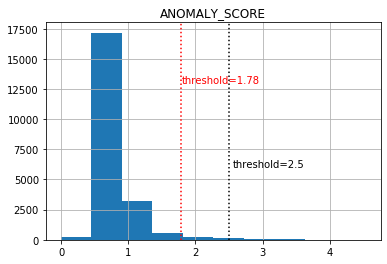

In [207]:
results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
results_pd.hist()
plt.axvline(x=1.78, linestyle=':', c='r')
plt.annotate('threshold=1.78', xy=(1.8,13000), color='r')
plt.axvline(x=2.5, linestyle=':', c='k')
plt.annotate('threshold=2.5', xy=(2.55,6000))
plt.show()

Determine the threshold to decide anomalous events. We chose 2.5 here.

In [205]:
threshold = 2.5

## 4. Plotting the Prediction

Like SageMaker RCF did, the algorithm detected anomalies accroding to the changes and deviations in each feature value instead of using a fixed threshold.

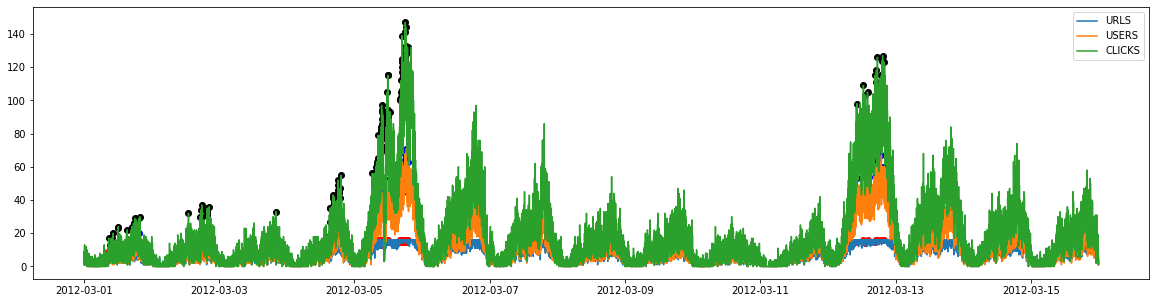

In [208]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['URLS','USERS','CLICKS']])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.legend(['URLS','USERS','CLICKS'])
plt.show()

The graph above may seem too complicated. Let's zoom in the arbitrary range to look at the results in more detail.

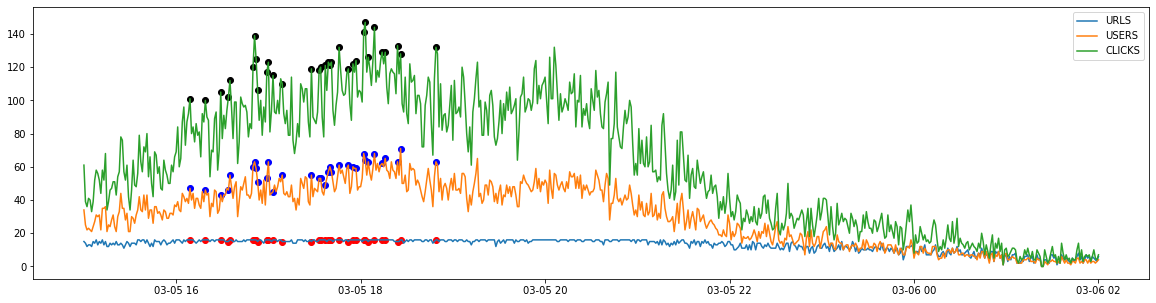

In [209]:
plt.figure(figsize=(20,5))
stime = "2012-03-05 15:00:00" # "2012-03-13 08:00:00"
etime = "2012-03-06 02:00:00" # "2012-03-13 23:00:00"

plt.plot(result_data[['URLS','USERS','CLICKS']][stime:etime])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])][stime:etime]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.legend(['URLS','USERS','CLICKS'])

plt.show()

This time, we have additional colomns which explain contribution of features. Plot the anomaly score and check which values most affected the anomaly score. 

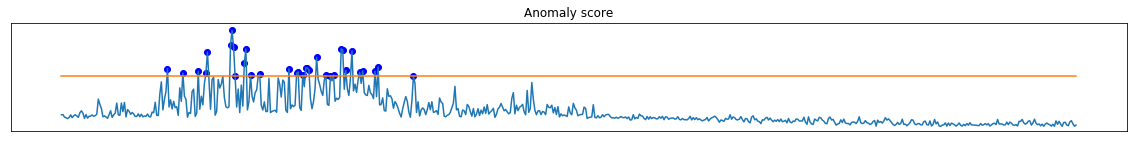

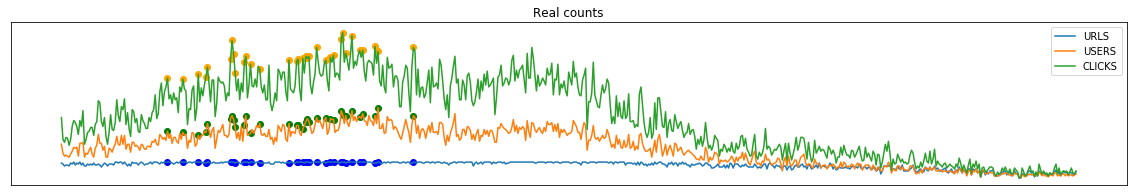

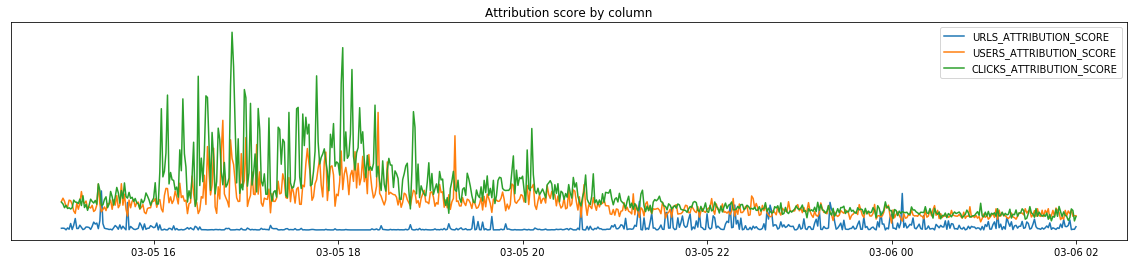

In [210]:
# Anormaly score graph
plt.figure(figsize=(20,2))
plt.title('Anomaly score')
plt.plot(result_data['ANOMALY_SCORE'][stime:etime])
plt.scatter(x= anomalous.index, y=anomalous['ANOMALY_SCORE'].values, c='blue')
plt.xticks([])
plt.yticks([])
# plt.yticks([1.0,2.0,3.0,4.0,5.5])
plt.plot(pd.DataFrame([threshold]*len(result_data[stime:etime].index)).set_index(result_data[stime:etime].index))
plt.show()

plt.figure(figsize=(20,3))
plt.title('Real counts')
plt.plot(result_data[['URLS','USERS','CLICKS']] [stime:etime])
plt.xticks([])
plt.yticks([])
plt.legend(['URLS','USERS','CLICKS'] )
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='green')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='orange')
plt.show()

# Attribution score graph
plt.figure(figsize=(20,4))
plt.title('Attribution score by column')
plt.plot(result_data[['URLS_ATTRIBUTION_SCORE','USERS_ATTRIBUTION_SCORE','CLICKS_ATTRIBUTION_SCORE']] [stime:etime])
# plt.xticks([])
plt.yticks([])
plt.legend(['URLS_ATTRIBUTION_SCORE','USERS_ATTRIBUTION_SCORE','CLICKS_ATTRIBUTION_SCORE'] )
# plt.scatter(x= anomalous.index, y=anomalous['URLS_ATTRIBUTION_SCORE'].values, c='blue')
# plt.scatter(x= anomalous.index, y=anomalous['USERS_ATTRIBUTION_SCORE'].values, c='green')
# plt.scatter(x= anomalous.index, y=anomalous['CLICKS_ATTRIBUTION_SCORE'].values, c='orange')
plt.show()

The graph at the bottom shows the portion to which each column contributed to the anomaly score.  
We can see that the number of clicks contributes a lot in general. And when the number of clicks or visitors does not change significantly, the number of pages contributes the most.(See the graph after 22:00 on 5th March.)

## 5. Stopping and Deleting the Kinesis Data Analytics Application

This is the end of the LAB. You can stop and delete the Kinesis Analytics Application using the following code.

In [186]:
kinesis_analytics.stop_application(ApplicationName=kinesis_ApplicationName)

# Wait until application stops running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('Stopping ')

while status != "READY":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
        ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write(os.linesep)

Stopping ....


In [187]:
kinesis_analytics.delete_application(ApplicationName=kinesis_ApplicationName,
                                     CreateTimestamp=response['ApplicationDetail']['CreateTimestamp'])

{'ResponseMetadata': {'RequestId': '756aba7c-989a-4c74-b44f-d5aba03d75d0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '756aba7c-989a-4c74-b44f-d5aba03d75d0',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Wed, 30 Sep 2020 14:02:50 GMT'},
  'RetryAttempts': 0}}

<br>  

---

## 6. (Optional) Comparison by timedecay parameter

When using RCF in Kiensis Analytics timedecay is one of the importatnt parameter. As Kinesis is dealing with streaming data, it is important to take time window into account. 

The next three datasets are Anomarly score results when timedecay values are set to 1440(1day), 4320(3days), and 100000(default), respectively. (You can easily create these dataset by running this notebook 3 times with different parameter.)

In [221]:
result_datasets = [result_data_1440, result_data_4320, result_data_100000 ]
titles = ['timedecay=1440','timedecay=4320','timedecay=100000']

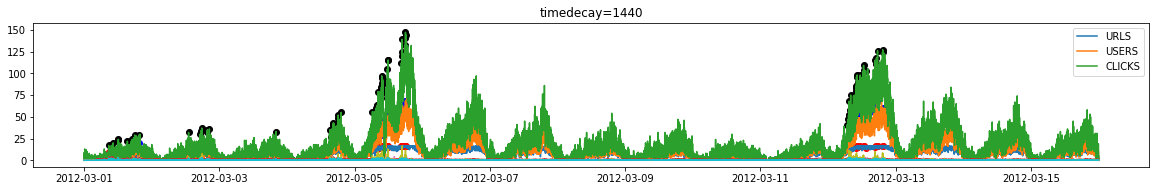

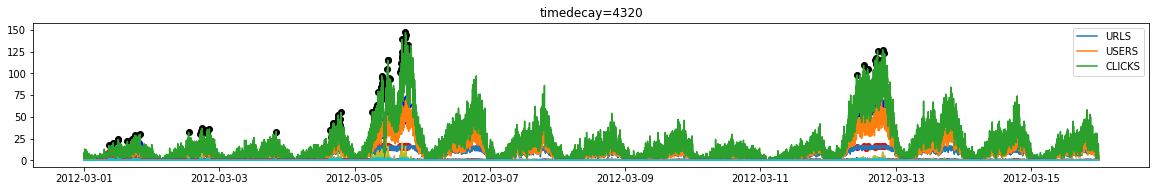

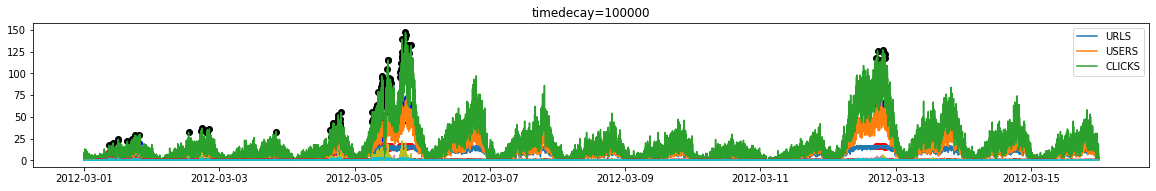

In [229]:
import warnings
warnings.filterwarnings("ignore")

for idx, result_data in enumerate(result_datasets):
    plt.figure(figsize=(20,9))
    plt.subplot(3,1, idx+1)
    plt.plot(result_data)
    results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
    anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]
    plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
    plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
    plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
    plt.legend(legend)
    plt.title(titles[idx])
    plt.show()

When watching points near 13th March, we can notice that the larger the timedecay value, the more tolerant of outliers. Given the nature of the timedecay parameter, this result is reasonable. If the timedecay value is small, the previous sample area to be considered is relatively small, so observations may be recognized as an unexpected pattern.

This is the last part of the Lab. Below is the last code zooming in around 13th March. 

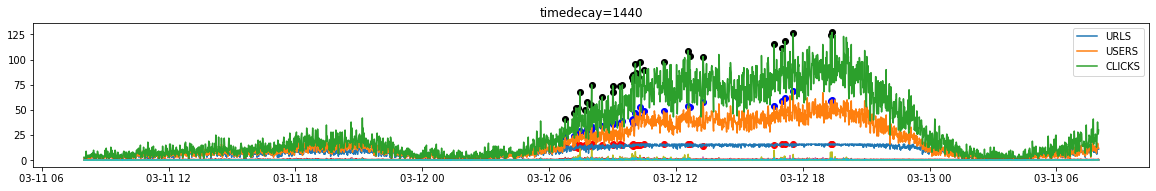

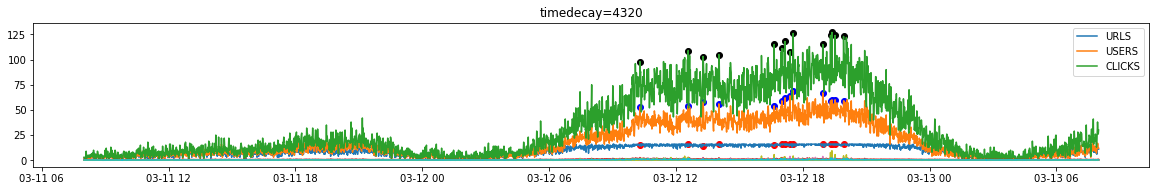

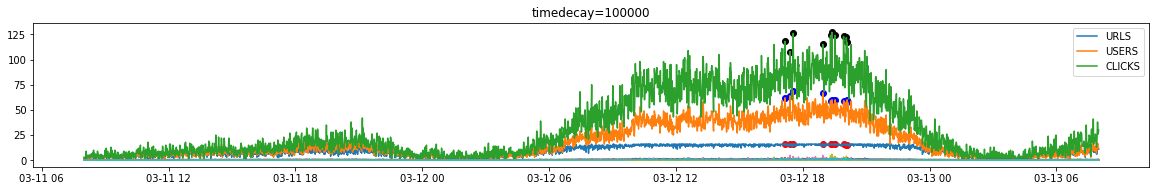

In [227]:
stime = "2012-03-11 08:00:00" 
etime = "2012-03-13 08:00:00" 

for idx, result_data in enumerate(result_datasets):
    plt.figure(figsize=(20,9))
    plt.subplot(3,1, idx+1)
    plt.plot(result_data[stime:etime])
    results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
    anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])][stime:etime]
    plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
    plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
    plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
    plt.legend(legend)
    plt.title(titles[idx])
    plt.show()

Hopefully all these experiments helped you understand AWS services.  
Thank you for your participation. 